In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob 
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
cancer_positive = glob("breastcancer/Cancer/*.jpg")
cancer_negative = glob("breastcancer/Negative/*.jpg")

In [3]:
print(f"Number of cancer positive: {len(cancer_positive)}")
print(f"Number of cancer negative: {len(cancer_negative)}")

Number of cancer positive: 410
Number of cancer negative: 410


In [4]:
IMG_SIZE = (224 ,224)

def load_images(folder):
    images = []
    labels = []

    for label in os.listdir(folder):
        class_folder = os.path.join(folder,label)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

    
            

In [5]:
X, y = load_images("breastcancer")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 42)

In [7]:
y_train = [1 if label == "Cancer" else 0 for label in y_train]
y_test = [1 if label == "Cancer" else 0 for label in y_test]

y_train = np.array(y_train)
y_test = np.array(y_test)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)




In [8]:
from sklearn.preprocessing import LabelEncoder

# Define the order explicitly
label_encoder = LabelEncoder()
label_encoder.fit(["Negative", "Cancer"])  # "Negative" → 0, "Cancer" → 1

# Transform labels
y = label_encoder.transform(y)

# Check the new mapping
print("Class mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Class mapping: {'Cancer': 0, 'Negative': 1}


In [9]:


# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(2, activation='softmax')  # Output layer (2 classes: Cancer & Negative)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
21/21 [==============================] - 25s 1s/step - loss: 0.7039 - accuracy: 0.6860 - val_loss: 0.3898 - val_accuracy: 0.8537
Epoch 2/10
21/21 [==============================] - 21s 998ms/step - loss: 0.3607 - accuracy: 0.8841 - val_loss: 0.3436 - val_accuracy: 0.8659
Epoch 3/10
21/21 [==============================] - 28s 1s/step - loss: 0.2605 - accuracy: 0.8887 - val_loss: 0.2929 - val_accuracy: 0.9085
Epoch 4/10
21/21 [==============================] - 22s 1s/step - loss: 0.2220 - accuracy: 0.9253 - val_loss: 0.2337 - val_accuracy: 0.8963
Epoch 5/10
21/21 [==============================] - 21s 1s/step - loss: 0.1646 - accuracy: 0.9345 - val_loss: 0.2353 - val_accuracy: 0.9085
Epoch 6/10
21/21 [==============================] - 21s 986ms/step - loss: 0.1593 - accuracy: 0.9421 - val_loss: 0.1911 - val_accuracy: 0.9390
Epoch 7/10
21/21 [==============================] - 21s 1s/step - loss: 0.0983 - accuracy: 0.9680 - val_loss: 0.1378 - val_accuracy: 0.9512
Epoch 8/10
21/

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

6/6 [==============================] - 2s 269ms/step - loss: 0.2298 - accuracy: 0.9268
Test Accuracy: 92.68%


In [27]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image at {image_path} not found or cannot be loaded.")
        return
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Reshape for model input

    prediction = model.predict(img)
    class_label = "Cancer" if np.argmax(prediction) == 1 else "Negative"

    print(f"Prediction: {class_label}")

# Test with an image
predict_image("breastcancer/Negative/9.jpg")  # Replace with your test image path


1/1 [==============================] - 0s 49ms/step
Prediction: Negative


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/20
21/21 [==============================] - 26s 1s/step - loss: 0.0404 - accuracy: 0.9924 - val_loss: 0.1792 - val_accuracy: 0.9573
Epoch 2/20
21/21 [==============================] - 25s 1s/step - loss: 0.0628 - accuracy: 0.9726 - val_loss: 0.1811 - val_accuracy: 0.9451
Epoch 3/20
21/21 [==============================] - 25s 1s/step - loss: 0.0573 - accuracy: 0.9817 - val_loss: 0.3352 - val_accuracy: 0.9085
Epoch 4/20
21/21 [==============================] - 24s 1s/step - loss: 0.0394 - accuracy: 0.9848 - val_loss: 0.1938 - val_accuracy: 0.9512


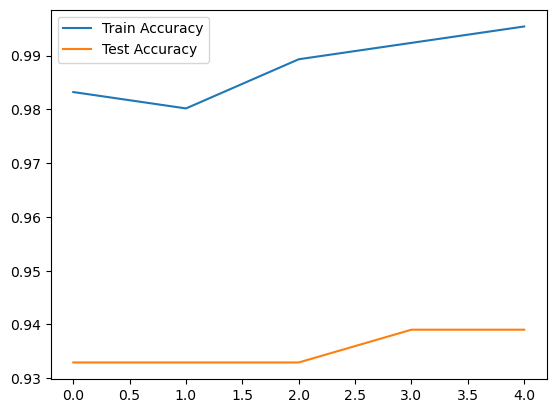

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()
